In [9]:
import zipfile
import os

In [10]:
# Define the paths to the zip files
train_zip_path = r'C:\Users\paupl\Downloads\monet_jpg.zip'
test_zip_path = r'C:\Users\paupl\Downloads\photo_jpg.zip'

# Define extraction directories
train_extract_dir = r'C:\Users\paupl\Downloads\monet_jpg'
test_extract_dir = r'C:\Users\paupl\Downloads\photo_jpg'


In [11]:
# Extract train images
with zipfile.ZipFile(train_zip_path) as zip_ref:
    zip_ref.extractall(train_extract_dir)

# Extract test images
with zipfile.ZipFile(test_zip_path) as zip_ref:
    zip_ref.extractall(test_extract_dir)

In [12]:
import tensorflow as tf
from PIL import Image

# Function to load images
def load_images_from_folder(folder, img_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path)  # Open the image file
            img = img.resize(img_size)  # Resize the image
            img = tf.keras.preprocessing.image.img_to_array(img)  # Convert to array
            images.append(img)
        except (IOError, OSError, ValueError) as e:
            print(f"Error loading image {img_path}: {e}")
    return tf.convert_to_tensor(images)

# Load training images
train_images = load_images_from_folder(train_extract_dir)

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Prepare the dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1024).batch(32)


Batch shape: (32, 256, 256, 3)


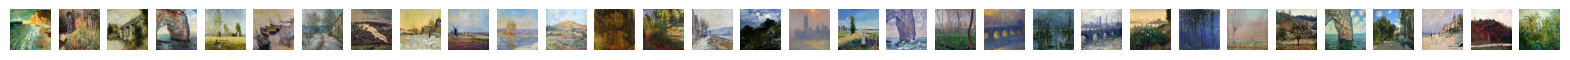

In [27]:
import matplotlib.pyplot as plt

# Function to display a batch of images
def display_batch_of_images(images_batch):
    fig, axes = plt.subplots(1, len(images_batch), figsize=(20, 20))
    for img, ax in zip(images_batch, axes):
        ax.imshow((img + 1) / 2)  # Convert back from [-1, 1] to [0, 1] for display
        ax.axis('off')
    plt.show()

# Take one batch from the dataset
for real_images in train_dataset.take(1):
    print(f"Batch shape: {real_images.shape}")
    # Display the first few images
    display_batch_of_images(real_images.numpy())
    break


In [28]:
from tensorflow.keras import layers, Sequential

# Discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    
    return model

# Instantiate the discriminator
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Print discriminator summary
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,891,201 (11.03 MB)

 Trainable params: 2,889,409 (11.02 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [17]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential

def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Set image shape to 256x256x3
img_shape = (256, 256, 3)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary to verify the architecture
discriminator.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,049 (6.42 MB)

 Trainable params: 1,682,049 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Generator model
def build_generator(latent_dim):
    model = Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((32, 32, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ], name='generator')
    
    return model

# Size of the random noise vector
latent_dim = 100

# Instantiate the generator
generator = build_generator(latent_dim)

# Print generator summary
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 262144)         │    26,214,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 262144)         │     1,048,576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 64, 64, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 128, 128, 64)   │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 256, 256, 3)    │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,922,176 (106.51 MB)

 Trainable params: 27,397,504 (104.51 MB)

 Non-trainable params: 524,672 (2.00 MB)

In [30]:
# Combined GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # We only want to train the generator in combined GAN model
    model = Sequential([
        generator,
        discriminator
    ])
    
    return model

# Instantiate the GAN model
gan = build_gan(generator, discriminator)

# Compile the GAN model
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Print GAN model summary
gan.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator (Sequential)          │ ?                      │    27,922,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ ?                      │     2,891,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,813,377 (117.54 MB)

 Trainable params: 27,397,504 (104.51 MB)

 Non-trainable params: 3,415,873 (13.03 MB)

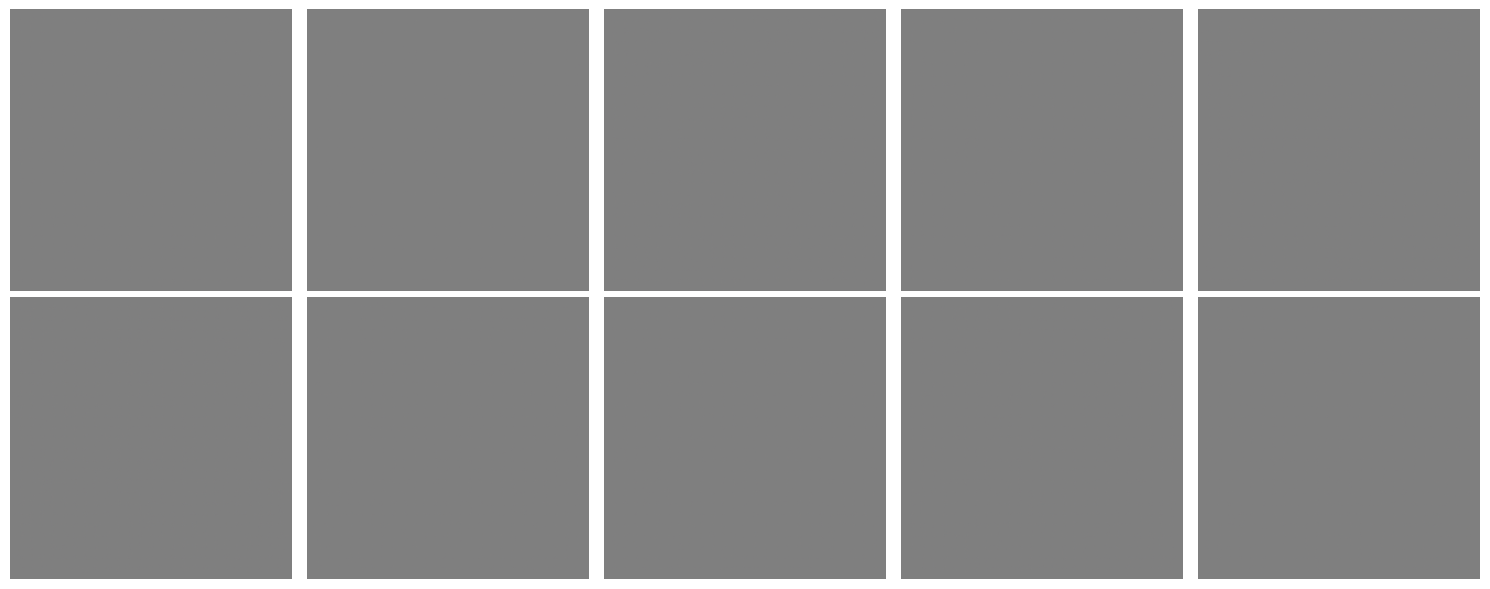

In [31]:
# Generate a batch of images
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = generator(random_latent_vectors, training=False)

# Plot the generated images
plt.figure(figsize=(15, 6))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow((generated_images[i] + 1) / 2)  # Scale images from [-1, 1] to [0, 1] for display
    plt.axis('off')
plt.tight_layout()
plt.show()